In [83]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from __future__ import print_function

import sys
sys.path.append('../../')
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable

from torchcv.models.rrd import RRD, RRDBoxCoder
from torchcv.loss import RRDLoss
from torchcv.datasets.textdataset import TextDataset
from torchcv.transforms import resize_quad, random_distort, random_paste_quad, random_crop_quad, random_flip_quad
from torchcv.utils import rec2quad

import PIL
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

In [85]:
img_size = 384

train_label_files = '/data1/fuwang/project/text/data/txt_9000'
train_image_files = '/data1/fuwang/project/text/data/image_9000'
test_image_files = '/data1/fuwang/project/text/data/train_1000/image_1000'
test_label_files = '/data1/fuwang/project/text/data/train_1000/txt_1000'
checkpoint = '/data1/fuwang/project/text/torchcv/checkpoint/ckpt2.pth'

print('Loading model..')
net = RRD(num_classes=2, input_size=img_size)
net.load_state_dict(torch.load(checkpoint)['net'])
net.cuda()
net.eval()

Loading model..


RRD(
  (extractor): VGG16Extractor300(
    (features): VGG16(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [86]:
print('Preparing dataset..')

def transform_train(img, boxes, labels):
    # print(type(img), type(boxes), type(labels))
    img = random_distort(img)
    if random.random() < 0.5:
        img, boxes = random_paste_quad(img, boxes, max_ratio=4, fill=(123,116,103))

    img, boxes, labels = random_crop_quad(img, boxes, labels)
    img, boxes = resize_quad(img, boxes, size=(img_size,img_size), random_interpolation=True)
    img, boxes = random_flip_quad(img, boxes)
    boxes, labels = box_coder.encode(boxes, labels)
    '''
    cls_prob = labels.float().unsqueeze(1).expand(-1, 2)
    cls_prob[:,0] *= -1
    cls_prob[:,0] += 1
    boxes, labels, scores = box_coder.decode(boxes, cls_prob, 0.6, 1, 1, False)
    '''
    return img, boxes, labels

trainset = TextDataset(img_root = train_image_files,
                       label_root = train_label_files,
                       transform=transform_train)

def transform_test(img, boxes, labels):
    img, boxes = resize_quad(img, boxes, size=(img_size,img_size))
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])(img)
    return img, boxes, labels

testset = TextDataset(img_root = test_image_files,
                      label_root = test_label_files,
                      transform=transform_test)
#dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
box_coder = RRDBoxCoder(net)

Preparing dataset..


In [87]:
def draw_bounds(im, locs, color):
    draw = ImageDraw.Draw(im)
    num = locs.shape[0]
    for i in range(num):
        draw.polygon(locs[i,:], outline=PIL.ImageColor.getcolor(color, mode=im.mode))
    del draw

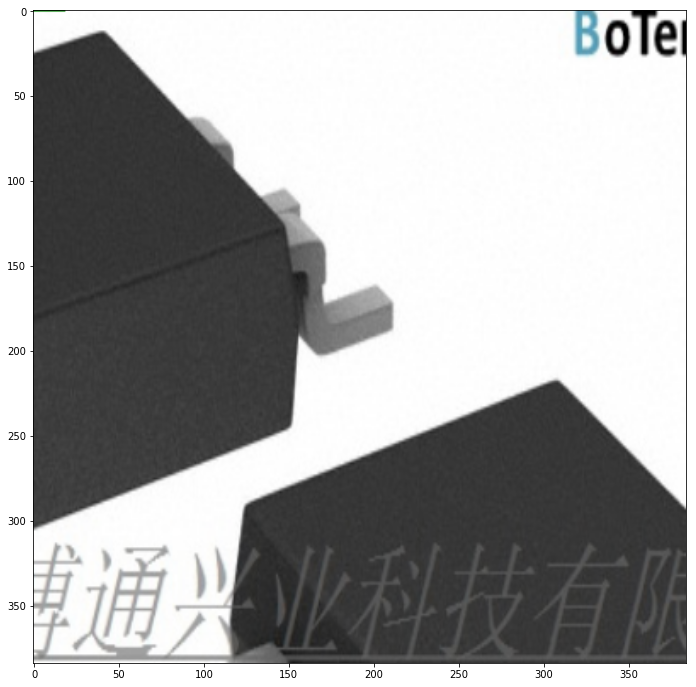

In [85]:
# test transform
i = random.randint(0, len(trainset)-1)
img, boxes0, labels0 = trainset[i]

'''
default_boxes = rec2quad(box_coder.default_boxes, 'xywh')
boxes1 = box_coder.default_boxes[:,2:].repeat(1,4) * boxes0 + default_boxes
boxes2 = boxes1[(labels0==1).nonzero().squeeze()]
'''

cls_prob = labels0.float().unsqueeze(1).repeat(1, 2)
cls_prob[:,0] = 1 - c[:,0]
boxes3, labels3, scores = box_coder.decode(boxes0, cls_prob, 0.6, 1, 1, False)

#draw_bounds(img, gt_boxes.numpy(), 'green')
draw_bounds(img, boxes3.numpy(), 'green')
plt.figure(figsize=(12,12))
plt.imshow(img, interpolation='bilinear')

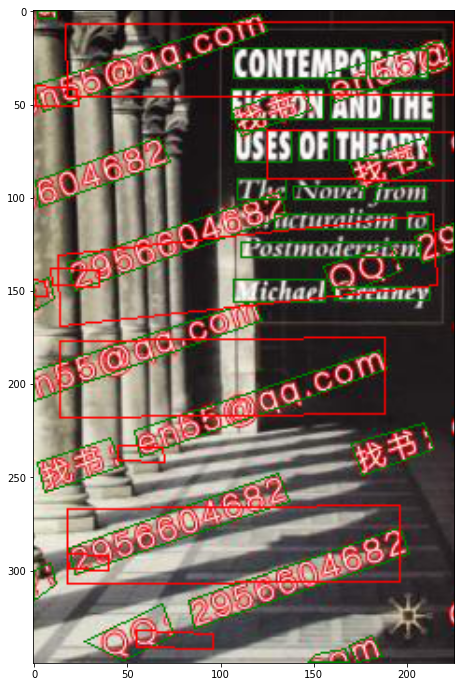

In [105]:
i = random.randint(0, len(testset)-1)
img_file = os.path.join(testset.img_root, testset.fnames[i] + '.jpg')


inputs, gt_boxes, gt_labels = testset[i]
inputs.unsqueeze_(0)

loc_preds, cls_preds = net(Variable(inputs.cuda(), volatile=True))
pred_boxes, pred_labels, pred_scores = box_coder.decode(
    loc_preds.cpu().data.squeeze(),
    F.softmax(cls_preds.squeeze(), dim=1).cpu().data, 0.502,0.5,0.2,True)

im = Image.open(img_file)
w_scale, h_scale = im.size[0] / img_size, im.size[1] / img_size
gt_boxes[:,[0,2,4,6]] *= w_scale
gt_boxes[:,[1,3,5,7]] *= h_scale
pred_boxes[:,[0,2,4,6]] *= w_scale
pred_boxes[:,[1,3,5,7]] *= h_scale
draw_bounds(im, gt_boxes.numpy(), 'green')
draw_bounds(im, pred_boxes.numpy(), 'red')
plt.figure(figsize=(12,12))
plt.imshow(im, interpolation='bilinear')